## [Chapter 6](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter6_Priorities/Ch6_Priors_PyMC3.ipynb)

Notes and exercises from Cam Davidson's *[Probabilistic Programming and Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)*.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter
from IPython.display import display
from scipy import stats
from scipy.misc import comb as nCk
from scipy.optimize import fmin
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdb

import daft
import theano.tensor as tt
import pymc3 as pm

np.random.seed(865)

'Done'

/home/alex/.envs/think-series/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'Done'

## Gamma Distribution

$$f(x \mid \alpha, \beta) = \frac{\beta^{\alpha}x^{\alpha-1}e^{-\beta x}}{\Gamma(\alpha)}$$

Can be used to model the waiting times between Poisson distributed events. The Gamma is a generalization of the Exponential: $\text{Exp}(\beta) = \text{Gamma}(1, \beta)$.

$\Gamma(\alpha)$ is the Gamma function, which is a generalization of the factorial to real and complex numbers, related by $\Gamma(n) = (n - 1)!$.

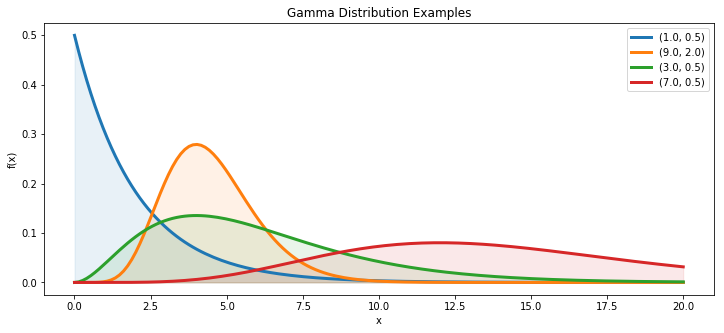

In [7]:
from math import gamma

plt.figure(figsize=(12, 5))

params = [(1, 0.5), (9, 2), (3, 0.5), (7, 0.5)]
X = np.linspace(0.001 ,20, 150)

for alpha, beta in params:
    Y = beta**alpha * X**(alpha - 1) * np.exp(-beta * X) / gamma(alpha)
    p = plt.plot(X, Y, label='(%.1lf, %.1lf)' % (alpha, beta), lw=3)
    plt.fill_between(X, 0, Y, color=p[0].get_color(), alpha=0.1)
    
    
plt.title('Gamma Distribution Examples')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

## Wishart Distribution

A distribution over all positive semi-definite matrices. Useful as a prior for covariance matrices.

Text(0.5,0.98,'Random matrices from a Wishart Distribution')

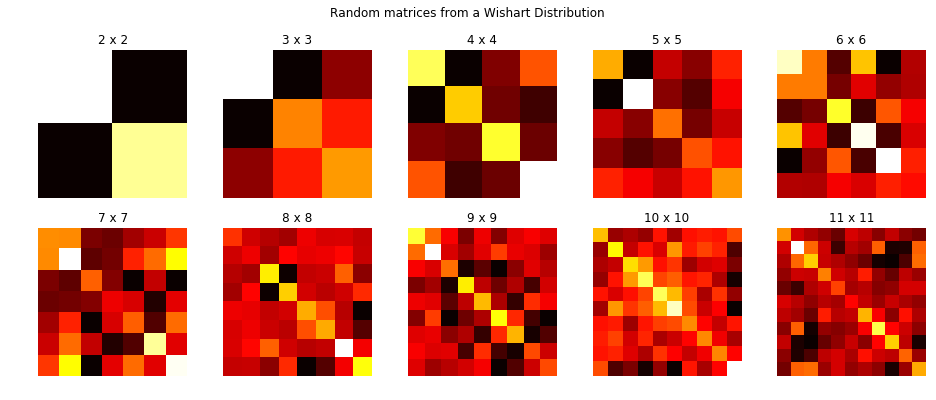

In [14]:
plt.figure(figsize=(16,6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    n = i + 2
    A = stats.wishart.rvs(n + 1, np.eye(n))
    plt.imshow(A, interpolation='none', cmap='hot')
    ax.set_title('%d x %d' % (n, n))
    ax.axis('off')
plt.suptitle('Random matrices from a Wishart Distribution')

## Beta Distribution

Useful for modeling values in $[0, 1]$: decimals, proportions, probabilities.

$\text{Beta}(1, 1)$ is equivalent to $\text{Uniform}(0, 1)$.

Further, a $\text{Beta}(1, 1)$ prior updated with a Binomial likelihood creates a Beta posterior. Specifically, prior $\text{Beta}(1, 1)$ updated with data $X \sim \text{Binomial}(N, p)$ yields posterior $\text{Beta}(1 + X, 1 + N - X)$. This is known as conjugacy and was also covered in [Think Bayes Chapter 4](https://github.com/alexklibisz/ml-exercises/blob/5c7a95a007fdeaa06e6474a696dfa28bfea1f01f/think-bayes/chap04.ipynb).

## Bayesian Multi-Armed Bandits


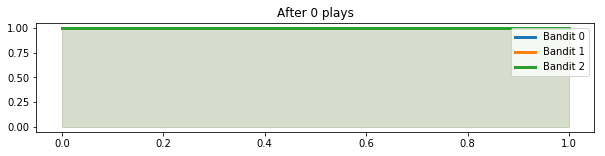

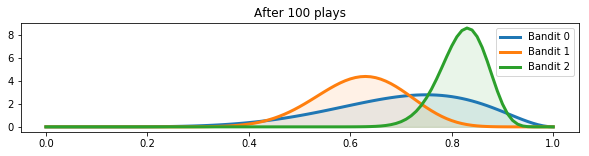

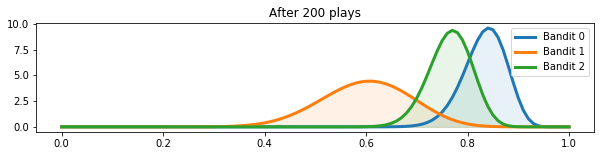

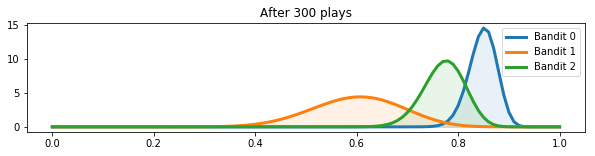

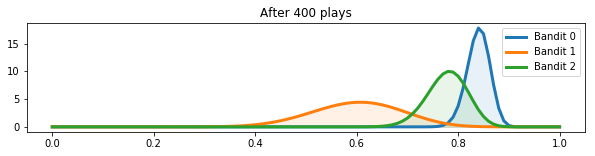

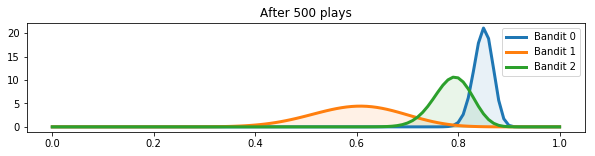

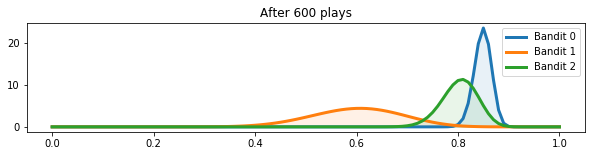

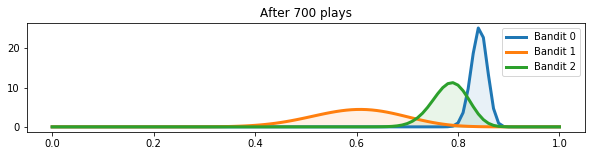

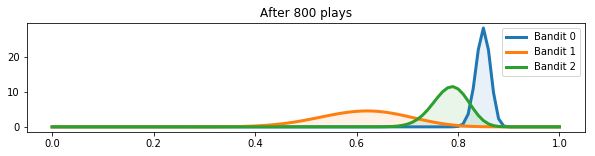

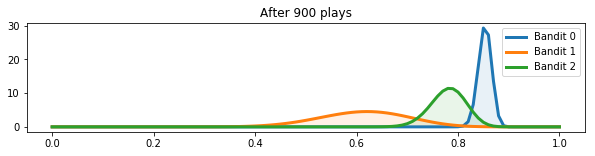

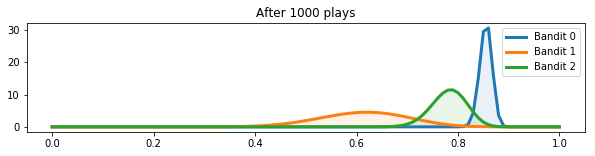

In [27]:
class Bandits(object):
    
    def __init__(self, P):
        self.P = np.array(P)
    
    def pull(self, i):
        return np.random.rand() < self.P[i]
    
    def __len__(self):
        return len(self.P)
    
class Player(object):
    
    def __init__(self, bandits):
        self.bandits = bandits
        self.alpha = np.ones(len(bandits))
        self.beta = np.ones(len(bandits))
        
    def play_once(self):
        sample = np.random.beta(self.alpha, self.beta)
        choice = np.argmax(sample)
        result = self.bandits.pull(choice)
        self.alpha[choice] += int(result == 1)
        self.beta[choice] += int(result == 0)
            
bandits = Bandits([0.85, 0.60, 0.75])
player = Player(bandits)

N = 1001

for i in range(N):
    
    if i % int(N / 10) == 0:
        plt.figure(figsize=(10, 2))
        X = np.linspace(0, 1, 101)
        for b in range(len(bandits)):
            Y = stats.beta.pdf(X, player.alpha[b], player.beta[b])
            p = plt.plot(X, Y, lw=3, label='Bandit %d' % b)
            plt.fill_between(X, 0, Y, color=p[0].get_color(), alpha=0.1)
        plt.title('After %d plays' % i)
        plt.legend()
        plt.show()
        
    player.play_once()

## Conjugate Priors

A prior chosen such that its updated posterior is the same distribution with different parameters is a conjugate prior. Conjugate priors are nice in that they have a closed form posterior, allowing you to circumvent MCMC sampling. Wikipedia has a [table of conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions).

## Jeffreys Priors

A uniform prior is not transformation invariant; that is, you can apply transformations that make it non-uniform. The idea behind Jeffreys Priors is to define an objective prior distribution that is invariant to transformations.